In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import torchvision
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [3]:
# load in train and test
train_data_csv = pd.read_csv("./data/sign_mnist_train.csv")
test_data_csv = pd.read_csv("./data/sign_mnist_test.csv")

In [4]:
# convert data to np arrays 
train_data = np.array(train_data_csv, dtype="float32")
test_data = np.array(test_data_csv, dtype="float32")

In [5]:
# 27k training cases; 7k test cases
print(train_data.shape)
print(test_data.shape)

(27455, 785)
(7172, 785)


In [6]:
# Split data into input image data and the label, convert to a Tensor, and create a TensorDataset for each set
train_tensor_set = torch.utils.data.TensorDataset(torch.Tensor(train_data[:, 1:].reshape(27455, 1, 28, 28)), torch.Tensor(train_data[:, 0]))
test_tensor_set = torch.utils.data.TensorDataset(torch.Tensor(test_data[:, 1:].reshape(7172, 1, 28, 28)), torch.Tensor(test_data[:, 0]))

In [7]:
# Include J and Z technically, but there won't be any data associated with them
classes =  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'] # not including the last letter for reduced computation. Not going to remove J for continuity in the indices, however

Label:  F


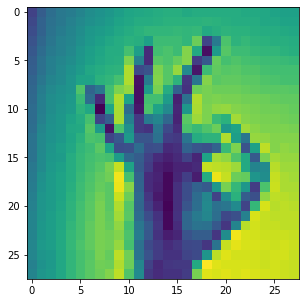

In [38]:
# Sample image display
num = random.randint(1, train_data.shape[0])
fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(train_data[num, 1:].reshape((28, 28)))
print("Label: ", classes[int(train_data[num, 0])])

Text(0.5, 1.0, 'Label Distributions')

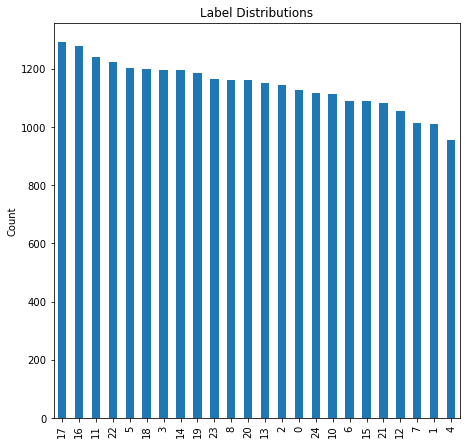

In [8]:
# Let's try something cool with the data
fig = plt.figure(figsize = (16, 16))
ax1 = fig.add_subplot(221)
train_data_csv['label'].value_counts().plot(kind='bar', ax=ax1)
# DISTRIBUTIONS of labels, look at x-axis for label indices
ax1.set_ylabel('Count')
ax1.set_title("Label Distributions")

In [32]:
# TODO Recalculate our means and standard deviations for the channels of our images, if necessary
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))
])
# first set is for means, second is for standard deviations. Im pretty sure we have to calculate them, but let's see if it works okay without lol

In [9]:
batch_size = 4 # Keep for now

# Creates an iterable for training dataset
trainloader = torch.utils.data.DataLoader(train_tensor_set, batch_size=batch_size, shuffle=True, num_workers=2)

# Creates an iterable for testing dataset
testloader = torch.utils.data.DataLoader(test_tensor_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [10]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # This is where a lot of the design process will happen since we have to decide layers and such
        # The current values need to be adjusted; we don't have to immediately go for the most complex one, we should just try to get the program running
        # with a simple model before we try to make it more complex.
        self.conv1 = nn.Conv2d(1, 32, 3) # The first value is the number of input channels (1, since we are using greyscale images)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(1600, 420) # TODO Research transition from Conv2D to Linear layers
        self.fc2 = nn.Linear(420, 69) 
        self.fc3 = nn.Linear(69, len(classes)) # the last int here has to be equal to the number of classes we are classifying for
    # Onwards!
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # relu cap the value between 0 and 1
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

In [11]:
# ONWARDS!
# Initialize optimizer and loss function
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.3)

In [58]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data 
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        # compute loss
        loss = criterion(outputs,labels.long())
        # compute gradients
        loss.backward()
        # Perform gradient descent step to modify parameters
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Ready for Tums!')

[1,  2000] loss: 1.405
[1,  4000] loss: 0.156
[1,  6000] loss: 0.050
[2,  2000] loss: 0.001
[2,  4000] loss: 0.000
[2,  6000] loss: 0.000
[3,  2000] loss: 0.000
[3,  4000] loss: 0.000
[3,  6000] loss: 0.000
[4,  2000] loss: 0.000
[4,  4000] loss: 0.000
[4,  6000] loss: 0.000


KeyboardInterrupt: 

In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)  
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 91 %


In [ ]:
PATH = './tums_net.pth'

In [ ]:
# Save the weights if they are looking good
torch.save(net.state_dict(), PATH)

In [15]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

RuntimeError: output with shape [1, 28, 28] doesn't match the broadcast shape [3, 28, 28]

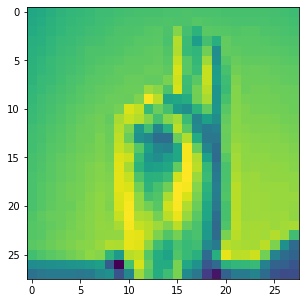

In [35]:
# Sample image prediction
with torch.no_grad():
    num = random.randint(1, test_data.shape[0])
    fig, ax = plt.subplots(figsize=(5, 5))
    image = test_data[num, 1:].reshape((28, 28))
    plt.imshow(image)

    prediction = net(mnist_transform(image))

    predicted = np.argmax(prediction)
    
    image = image.reshape(28, 28, 1)

    print("Predicted Label: ", classes[predicted])
    print("Actual Label: ", classes[int(test_data[num, 0])])

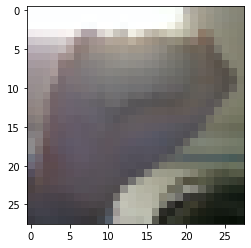

In [30]:
# Importing Image class from PIL module
from PIL import Image

# Opens a image in RGB mode
im = Image.open(r"data\SampleA.jpg")

# Size of the image in pixels (size of original image)
# (This is not mandatory)
width, height = im.size

# Setting the points for cropped image
left = 381
top = 135
right = left + 527
bottom = top + 527

# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
newsize = (28, 28)
im1 = im1.resize(newsize)
# Shows the image in image viewer
plt.imshow(im1)

# credit to https://www.geeksforgeeks.org/python-pil-image-resize-method/

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 1, 3, 3], but got 3-dimensional input of size [3, 28, 28] instead

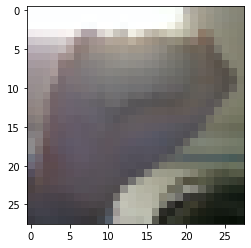

In [37]:
# Sample image prediction
with torch.no_grad():

    plt.imshow(im1)

    prediction = net(mnist_transform(im1))

    predicted = np.argmax(prediction)
    
    image = im1.reshape(28, 28, 1)

    print("Predicted Label: ", classes[predicted])
    print("Actual Label: A")